####  7Twelve Portfolio
* This notebook reproduces the charts in the blog article: [Retirement Portfolio-7Twelve](http://appliedvalueinvestor.com/2017/09/10/retirement-portfolio-7twelve/)

In [1]:
### Setup the environment
import os,sys
import pandas as pd
import pandas_datareader as web
import numpy as np
from datetime import datetime as dt
import matplotlib
import seaborn as sns
#%matplotlib inline
import pylab as py
py.ion()

import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import warnings
warnings.filterwarnings('ignore')

HOME=os.environ['HOME']
file_path = os.path.dirname(os.path.realpath('__file__'))
sys_path='%s/..'%file_path
sys.path.append(sys_path)
from investmenttools import PortfolioBuilder as PB
reload(PB)

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
## Portfolio ticker
n712=['ITOT', 'SCHM', 'VBR', 'VEU', 'SCHE', 'VNQ', 'VAW', 'AGG', 'SCHP', 'IGOV', 'SHV','DBC']
n711=['ITOT', 'SCHM', 'VBR', 'VEU', 'SCHE', 'VNQ', 'VAW', 'AGG', 'SCHP', 'IGOV', 'SHV']
nPP=['ITOT','SHY','TLT','IAU']
nBP=['ITOT','SHY']

## List of ETFs for which need to download data
combined_ticker=list(set.union(set(n712),set(n711),set(nBP),set(nPP)))

## Portfolio Weight
w712=12*[0.08333]
w711=11*[0.090909]
wPP=4*[0.25]
wBP=[0.1,0.9]

In [3]:
## Define python module to download ticker data
from selenium import webdriver
from time import mktime
from xvfbwrapper import Xvfb

def WaitForDownload(datafile):
    bul=0
    while not bul:
        if os.path.isfile(datafile):
            bul=1
        else:
            bul=0

def download_ticker(ticker,sd,ed):
    vdisplay=Xvfb()
    sd_unix=mktime(sd.timetuple())
    ed_unix=mktime(ed.timetuple())
    URL='https://finance.yahoo.com/quote/%s/history?period1=%d&period2=%d&interval=1d&filter=history&frequency=1d'%(ticker.upper(),sd_unix,ed_unix)
    print URL
    #vdisplay.start() ## uncomment to prevent browser window from opening 
    driver=webdriver.Chrome()
    driver.get(URL)
    driver.implicitly_wait(100)
    elem=driver.find_element_by_link_text('Download Data')
    elem.click()
    datafile='%s/Downloads/%s.csv'%(HOME,ticker.upper())
    WaitForDownload(datafile)
    #assert os.path.isfile(datafile)
    mv_cmd='mv %s/Downloads/%s.csv %s/../Data'%(HOME,ticker.upper(),file_path)
    
    os.system(mv_cmd)
    #vdisplay.stop() ## uncomment to prevent browser window from opening 
    driver.close()    
    
## Define python module to read ticker data from csv file downloaed from Yahoo-finance
def get_data_from_csv(filename,ticker):
	data=pd.read_csv(filename)
	data.set_index('Date',inplace=True)
	data.rename(columns={'Close':ticker},inplace=True)
	data=data[ticker]
	return data

In [ ]:
# Download data
## Not running this again, as I already downloaded the data
for s in combined_ticker:
    print s
    download_ticker(s.upper(),dt(2012,1,1),dt(2017,8,31))


In [4]:
#Collate portfolio data

data_712={};data_711={};data_PP={};data_BP={}

for s in n712:
    data_712[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_712=pd.DataFrame(data_712.values()).T 
portfolio_712.dropna(inplace=True)
portfolio_712.index=pd.to_datetime(portfolio_712.index)

for s in n711:
    data_711[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_711=pd.DataFrame(data_711.values()).T  
portfolio_711.dropna(inplace=True)
portfolio_711.index=pd.to_datetime(portfolio_711.index)

for s in nPP:
    data_PP[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_PP=pd.DataFrame(data_PP.values()).T  
portfolio_PP.dropna(inplace=True)
portfolio_PP.index=pd.to_datetime(portfolio_PP.index)

for s in nBP:
    data_BP[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_BP=pd.DataFrame(data_BP.values()).T  
portfolio_BP.dropna(inplace=True)
portfolio_BP.index=pd.to_datetime(portfolio_BP.index)
## sanity check
print portfolio_BP.head(5)

              SHY    ITOT
Date                     
2012-01-03  84.45  28.975
2012-01-04  84.46  28.980
2012-01-05  84.47  29.050
2012-01-06  84.46  29.000
2012-01-09  84.48  29.075


In [5]:
## Compute Portfolio Variance

s712=PB.calc_portfolio_var(portfolio_712,w712)
s711=PB.calc_portfolio_var(portfolio_711,w711)
sPP=PB.calc_portfolio_var(portfolio_PP,wPP)
sBP=PB.calc_portfolio_var(portfolio_BP,wBP)

All_Var=[s712,s711,sPP,sBP]

print 'Var fo 712:',s712
print 'Var fo 711:',s711
print 'Var fo PP:',sPP
print 'Var fo BP:',sBP


Var fo 712: 15.2572487021
Var fo 711: 21.2318709676
Var fo PP: 9.46752389611
Var fo BP: 44.9629931528


In [6]:
## Compute Portfolio returns with annual rebalancing
r712=PB.Backtest_Annual_Rebalance(n712,w712,dt(2012,1,1),dt(2017,8,31),initial=10000,stk_data=portfolio_712)
r711=PB.Backtest_Annual_Rebalance(n711,w711,dt(2012,1,1),dt(2017,8,31),initial=10000,stk_data=portfolio_711)
rPP=PB.Backtest_Annual_Rebalance(nPP,wPP,dt(2012,1,1),dt(2017,8,31),initial=10000,stk_data=portfolio_PP)
rBP=PB.Backtest_Annual_Rebalance(nBP,[0.9,0.1],dt(2012,1,1),dt(2017,8,31),initial=10000,stk_data=portfolio_BP)

In [7]:
## Compute Annual Returns
P712_dp=PB.calc_daily_returns(r712[['Total','Cash']].sum(axis=1))
P712_ap=100*PB.calc_annual_returns(P712_dp)
P712_ap.name='712'

P711_dp=PB.calc_daily_returns(r711[['Total','Cash']].sum(axis=1))
P711_ap=100*PB.calc_annual_returns(P711_dp)
P711_ap.name='711'

PP_dp=PB.calc_daily_returns(rPP[['Total','Cash']].sum(axis=1))
PP_ap=100*PB.calc_annual_returns(PP_dp)
PP_ap.name='PP'

BP_dp=PB.calc_daily_returns(rBP[['Total','Cash']].sum(axis=1))
BP_ap=100*PB.calc_annual_returns(BP_dp)
BP_ap.name='BP'

Annual_Returns=pd.concat([P712_ap,P711_ap,PP_ap,BP_ap],axis=1)
print Annual_Returns

print '\n Average Annual Returns:'
avg_annual_returns=Annual_Returns.mean(axis=0)
print avg_annual_returns

        712    711     PP      BP
2012  8.137  8.812  4.365  10.831
2013  6.710  7.966 -3.994  24.413
2014  1.651  4.385  8.015   9.887
2015 -7.696 -5.925 -3.878  -2.016
2016  9.401  8.433  3.981  10.858
2017  5.301  6.484  7.105   7.808

 Average Annual Returns:
712     3.917
711     5.026
PP      2.599
BP     10.297
dtype: float64


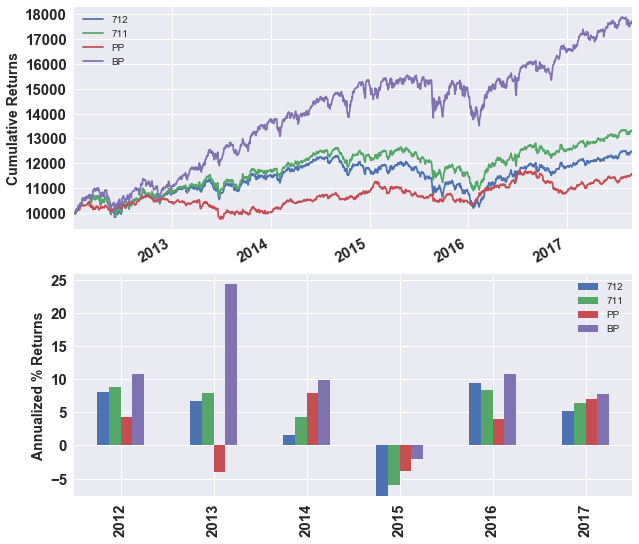

In [17]:
## Plot Cumulative And Annual Returns

py.figure(figsize=(10,10))
ax1=py.subplot(211)
py.hold('on')
r712[['Total','Cash']].sum(axis=1).plot(ax=ax1)
r711[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rPP[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rBP[['Total','Cash']].sum(axis=1).plot(ax=ax1)
py.xticks(fontsize=15,fontweight='bold')
py.yticks(fontsize=15,fontweight='bold')
py.ylabel('Cumulative Returns',fontweight='bold',fontsize=14)
py.xlabel('')
py.legend(['712','711','PP','BP'],loc='best')

ax2=py.subplot(212)
Annual_Returns.plot(kind='bar',ax=ax2)
py.xticks(fontsize=15,fontweight='bold');
py.yticks(fontsize=15,fontweight='bold');
py.ylabel('Annualized % Returns',fontweight='bold',fontsize=14)


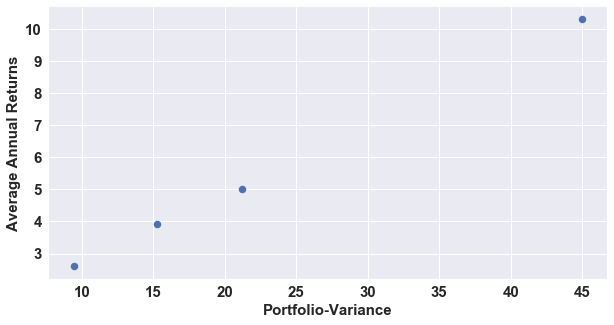

In [9]:
## Print Risk Return Profile

py.figure(figsize=(10,5));
py.plot(All_Var,avg_annual_returns.values,'.',markersize=15)
py.xticks(fontweight='bold',fontsize=15)
py.yticks(fontweight='bold',fontsize=15)
py.xlabel('Portfolio-Variance',fontweight='bold',fontsize=15)
py.ylabel('Average Annual Returns',fontweight='bold',fontsize=15)

## Perfect straiht line!!!!! quite unusall 